# Processing: Load, Chunk, and Prepare for Vector DB

This notebook demonstrates a step-by-step approach to loading, enriching,
chunking, and storing documents into a vector database.
It compares different outputs at each stage interactively with helpful visualizations.

Create from scratch a chain that: 
- takes an input document. (In this case many Arxiv pdf documents.)
- Chunks the document, keeping the metadata.
- Embed the document chunks.
- Saves the embeddings into a vector DB.

In [1]:
from langchain_community.document_loaders import ArxivLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer
from langchain.schema import Document
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from langchain.embeddings import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Qdrant
from sklearn.decomposition import PCA
import pandas as pd
import plotly.express as px


In [2]:

# Supports all arguments of `ArxivAPIWrapper`
loader = ArxivLoader(
    query="LLM",
    load_max_docs=50,
    top_k_results=20
    # doc_content_chars_max=1000,
    # load_all_available_meta=False,
    # ...
)

In [3]:
docs = loader.load()
len(docs)


20

# Splitter

In [4]:
# V1 : Selecting the modelID from HF and the tokenizer, choosing a model
model_id = "sentence-transformers/all-mpnet-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_id)
text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer,
    chunk_size=300,
    chunk_overlap=30,
    add_start_index=True,
    strip_whitespace=True,
    #separators=["\n\n", "\n", ".", " ", ""],
)

In [5]:
vars(docs[0])

{'id': None,
 'metadata': {'Published': '2024-12-23',
  'Title': 'Trustworthy and Efficient LLMs Meet Databases',
  'Authors': 'Kyoungmin Kim, Anastasia Ailamaki',
  'Summary': 'In the rapidly evolving AI era with large language models (LLMs) at the core,\nmaking LLMs more trustworthy and efficient, especially in output generation\n(inference), has gained significant attention. This is to reduce plausible but\nfaulty LLM outputs (a.k.a hallucinations) and meet the highly increased\ninference demands. This tutorial explores such efforts and makes them\ntransparent to the database community. Understanding these efforts is essential\nin harnessing LLMs in database tasks and adapting database techniques to LLMs.\nFurthermore, we delve into the synergy between LLMs and databases, highlighting\nnew opportunities and challenges in their intersection. This tutorial aims to\nshare with database researchers and practitioners essential concepts and\nstrategies around LLMs, reduce the unfamiliarit

# Chunking

In [6]:
final_chunks = []
chunk_by_doc = {}
for doc in docs:
    doc_chunks = []
    for i, chunk in enumerate(text_splitter.split_text(doc.page_content)):
        metadata = doc.metadata.copy()
        metadata["chunk_index"] = i
        doc_chunks.append(Document(page_content=chunk, metadata=metadata))
    chunk_by_doc[doc.metadata.get("Title", "Document")] = (
        doc_chunks
    )
    final_chunks.extend(doc_chunks)

In [7]:
chunk_lengths = [
    len(tokenizer.encode(chunk.page_content, truncation=False))
    for chunk in final_chunks
]

print(f"\n--- Chunk Stats : model_id defined splitter ---")
print(f"Total chunks: {len(final_chunks)}")
print(
    f"Avg size: {np.mean(chunk_lengths):.2f}, Max: {np.max(chunk_lengths)}, Min: {np.min(chunk_lengths)}"
)


--- Chunk Stats : model_id defined splitter ---
Total chunks: 1697
Avg size: 293.11, Max: 302, Min: 48


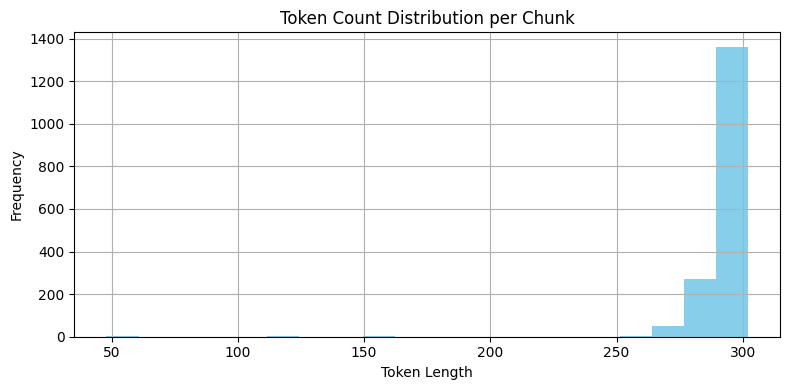

In [8]:
# Histogram of model_id Chunk Sizes
plt.figure(figsize=(8, 4))
plt.hist(chunk_lengths, bins=20, color="skyblue")
plt.title("Token Count Distribution per Chunk")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# VISUALIZING CHUNKING 1

doc_selector = widgets.Dropdown(
    options=list(chunk_by_doc.keys()),
    description="Document:",
    layout=widgets.Layout(width="50%"),
)

chunk_slider = widgets.IntSlider(min=0, max=1, step=1, description="Chunk:")

output_area = widgets.Output()


def update_slider(*args):
    selected_doc = doc_selector.value
    chunk_slider.max = len(chunk_by_doc[selected_doc]) - 1
    chunk_slider.value = 0
    show_chunk(0)


def show_chunk(i):
    with output_area:
        output_area.clear_output()
        selected_doc = doc_selector.value
        chunk = chunk_by_doc[selected_doc][i]
        print(chunk.metadata)
        print("\n" + chunk.page_content[:1000])


chunk_slider.observe(lambda change: show_chunk(change["new"]), names="value")
doc_selector.observe(update_slider, names="value")

display(widgets.VBox([doc_selector, chunk_slider, output_area]))
update_slider()

In [14]:
# ## Step 3: Store in Qdrant Vector DB

embedding = HuggingFaceEmbeddings(model_name=model_id)

db = Qdrant.from_documents(
    documents=final_chunks,
    embedding=embedding,
    location="localhost:6333",
    collection_name="LLM-papers all-mpnet-base-v2",
    prefer_grpc=False,
)

print("\n--- Stored in Qdrant Vector DB ---")
print(f"Collection: {db.collection_name}")


--- Stored in Qdrant Vector DB ---
Collection: LLM-papers all-mpnet-base-v2


In [11]:
# Run PCA
texts = [doc.page_content for doc in final_chunks]
embeddings = embedding.embed_documents(texts)

In [12]:
pca = PCA(n_components=2)
points = pca.fit_transform(embeddings)

# Create color group
doc_names = [
    doc.metadata.get("Title", "Doc " + str(i))
    for i, doc in enumerate(final_chunks)
]
unique_doc_ids = {name: i for i, name in enumerate(set(doc_names))}
colors = [unique_doc_ids[name] for name in doc_names]

# DataFrame for plot
df = pd.DataFrame({
    "x": points[:, 0],
    "y": points[:, 1],
    "document": doc_names,
    "chunk": [doc.metadata.get("chunk_index", 0) for doc in final_chunks],
    "preview": [doc.page_content[:100].replace("\n", " ") for doc in final_chunks],
    "color_id": colors
})

In [13]:
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="color_id",
    hover_data=["document", "chunk", "preview"],
    title="Interactive PCA Projection of Chunks"
)
fig.update_traces(marker=dict(size=6, opacity=0.6))
fig.update_layout(showlegend=False)
fig.show()